# Analysis Of Trump and Biden Twitter Followers

#### First all of the import statements we will need

In [33]:
from tqdm import tqdm
import os
import twint
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import csv
import math
from math import log2
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB

#### Loading our matrices that we scraped from twitter using [Twint](https://github.com/twintproject/twint)

In [34]:
# a 442by84 matrix. There are 442 followers, half following Biden and half following Trump, and we analyze 84
# different accounts that these followers follow (we will from here on out refer to these accounts as teams. Whether 
# or not they follow a team is represented in binary in this matrix
matrix = np.load('matrix.npy')

# a binary vector of length 442. 0's represent Biden followers and 1's represent Trump followers
targetArray = np.load('tagetArray.npy')

# A list of the names of the 84 teams in the same order as in 'matrix'
topTeamsListMessy = np.load('topTeamsList.npy')

#### We have to clean up 'topTeamsListMessy' because it has a bunch of unwanted symbols in it

In [35]:
def cleanTeamsList(teamsList):
    cleanList = []
    for user in teamsList:
        cleanUser = user[2:-3]
        cleanList.append(cleanUser)
    return cleanList

topTeamsList = cleanTeamsList(topTeamsListMessy)

### Taking a quick look at what our data looks like

#### To start we just want to see how many of the top 84 teams an average Trump or Biden follower follows

In [36]:
def averageFollowing(matrix1, matrix2, classification):
    totalInClass = 0
    totalFollowing = 0
    for i in range(len(matrix2)):
        if (matrix2[i] == classification):
            totalInClass += 1;
            for e in matrix1[i]:
                if (e == 1):
                    totalFollowing += 1;
    return totalFollowing / totalInClass

print("Biden followers follow " + str(averageFollowing(matrix, targetArray, 0)) + " of the 84 teams on average")
print("Trump followers follow " + str(averageFollowing(matrix, targetArray, 1)) + " of the 84 teams on average")

Biden followers follow 7.285046728971962 of the 84 teams on average
Trump followers follow 4.798245614035087 of the 84 teams on average


#### From this we can see that Biden followers follow more of the popular teams than Trump followers. Lets see what the distributions of how many of the teams they follow look like

In [37]:
def createFollowingList(matrix1, matrix2, classification):
    followingList = []
    for i in range(len(matrix2)):
        if (matrix2[i] == classification):
            numFollowing = 0
            for e in matrix1[i]:
                if (e == 1):
                    numFollowing += 1;
            followingList.append(numFollowing)
    return followingList

bidenFollowingList = createFollowingList(matrix, targetArray, 0)
trumpFollowingList = createFollowingList(matrix, targetArray, 1)

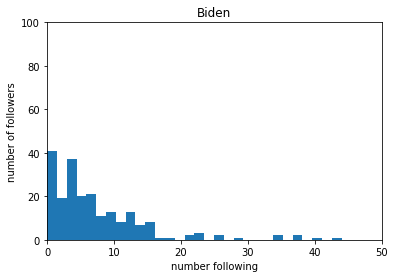

In [38]:
plt.hist(bidenFollowingList, bins = 30)
plt.title('Biden')
plt.xlim(0, 50)
plt.ylim(0, 100)
plt.ylabel('number of followers')
plt.xlabel('number following');

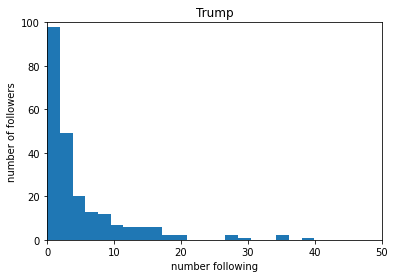

In [39]:
plt.hist(trumpFollowingList, bins = 30)
plt.title('Trump')
plt.xlim(0, 50)
plt.ylim(0, 100)
plt.ylabel('number of followers')
plt.xlabel('number following');

#### The distributions of the two look a little different. Biden followers are fairly spread out as too how many of the top teams they follow whereas Trump followers seem to either follow just a few teams or a ton. Not many Trump followers follow an amount in the middle.

#### Not a lot of interesting conclusions to be made here so lets move on to Entropy Analysis

## Entropy Analysis (Section needs to be commented on)

In [40]:
def createSubgroups(matrix, targetArray, teamsList, teamSpec):
    listOfTeam = []
    listOfNotTeam = []
    teamTargetArray = []
    notTeamTargetArray = []
    
    for index, team in enumerate(teamsList):
        if team == teamSpec:
            teamIndex = index
    for index2, person in enumerate(matrix):
        if person[teamIndex] == 1:
            listOfTeam.append(person)
            if int(targetArray[index2]) == 1:
                teamTargetArray.append(1)
            else:
                teamTargetArray.append(0)
        else:
            listOfNotTeam.append(person)
            if int(targetArray[index2]) == 1:
                notTeamTargetArray.append(1)
            else:
                notTeamTargetArray.append(0)
    return listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray

listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, 'KamalaHarris')

print("KAMALAHARRIS")
print("Length of team matrix: ", len(listOfTeam))
print("Length of NOT team matrix: ", len(listOfNotTeam))


KAMALAHARRIS
Length of team matrix:  130
Length of NOT team matrix:  312


In [41]:
def findTrumpBiden(group, targetArray):
    countTrump = 0
    countBiden = 0
    for index, person in enumerate(group):
        if targetArray[index] == 1:
            countTrump += 1
        else:
            countBiden += 1
    return countTrump, countBiden
countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
print("POTUS Biden: ", countBiden)
print("POTUS Trump: ", countTrump)

POTUS Biden:  101
POTUS Trump:  29


In [42]:
def shannonEntropy(vector):

    listOfElements = []
    for p in vector:
        if p > 0:
            element = p*log2(p)
            listOfElements.append(element)
        else:
            element = 0
            listOfElements.append(element)
        entropy = -1 * sum(listOfElements)
    return entropy

In [43]:
def findShannonEntropy(groupTeam, teamTargetArray, matrix):
    countTrumpTeam, countBidenTeam = findTrumpBiden(groupTeam, teamTargetArray)
    if (countTrumpTeam + countBidenTeam) != 0:
        probTrumpTeam = countTrumpTeam / (countTrumpTeam + countBidenTeam)
        probBidenTeam = countBidenTeam / (countTrumpTeam + countBidenTeam)
    else:
        probTrumpTeam = 0
        probBidenTeam = 0

    probTeamVector = [probTrumpTeam, probBidenTeam]
    sEntropy = shannonEntropy(probTeamVector)
    return sEntropy

In [44]:
def findWeightedShannonEntropy(groupTeam, teamTargetArray, matrix):
    countTrumpTeam, countBidenTeam = findTrumpBiden(groupTeam, teamTargetArray)
    if (countTrumpTeam + countBidenTeam) != 0:
        probTrumpTeam = countTrumpTeam / (countTrumpTeam + countBidenTeam)
        probBidenTeam = countBidenTeam / (countTrumpTeam + countBidenTeam)
    else:
        probTrumpTeam = 0
        probBidenTeam = 0

    probTeamVector = [probTrumpTeam, probBidenTeam]
    sEntropy = shannonEntropy(probTeamVector)
    wae = sEntropy * (len(groupTeam)/len(matrix))
    return wae

waeTeam = findWeightedShannonEntropy(listOfTeam, teamTargetArray, matrix)
waeNotTeam = findWeightedShannonEntropy(listOfNotTeam, notTeamTargetArray, matrix)
print("Weighted Average Entropy of team of POTUS User: ", waeTeam)
print("Weighted Average Entropy of NOT team of POTUS User:", waeNotTeam)

Weighted Average Entropy of team of POTUS User:  0.22521947302504128
Weighted Average Entropy of NOT team of POTUS User: 0.6666899774749303


In [45]:
def getSplitWAE(groupTeam, groupNotTeam, teamTargetArray, notTeamTargetArray, matrix):
        wae1 = findWeightedShannonEntropy(groupTeam, teamTargetArray, matrix)
        
        wae2 = findWeightedShannonEntropy(groupNotTeam, notTeamTargetArray, matrix)

        return (wae1 + wae2)

10 Lowest Entropies:  [('KamalaHarris', 0.8919094504999716), ('BarackObama', 0.9469477457556994), ('ArianaGrande', 0.9529453112140598), ('SidneyPowell1', 0.9546119031023518), ('MichelleObama', 0.958975521722012), ('rihanna', 0.9647668343235515), ('NICKIMINAJ', 0.9660898111710107), ('KylieJenner', 0.9695709730344851), ('TrumpWarRoom', 0.9705844310763023), ('kayleighmcenany', 0.9718664627470197)]
10 Highest Entropies:  [('ABC', 0.9992670226986101), ('espn', 0.9992670226986101), ('Twitter', 0.9990524568763821), ('jimmyfallon', 0.9990509447928101), ('NatGeo', 0.99904579377482), ('StephenAtHome', 0.99904579377482), ('SportsCenter', 0.99904579377482), ('DrBiden', 0.9987279314906236), ('BillGates', 0.9983180476184748), ('NFL', 0.9982796895058352)]


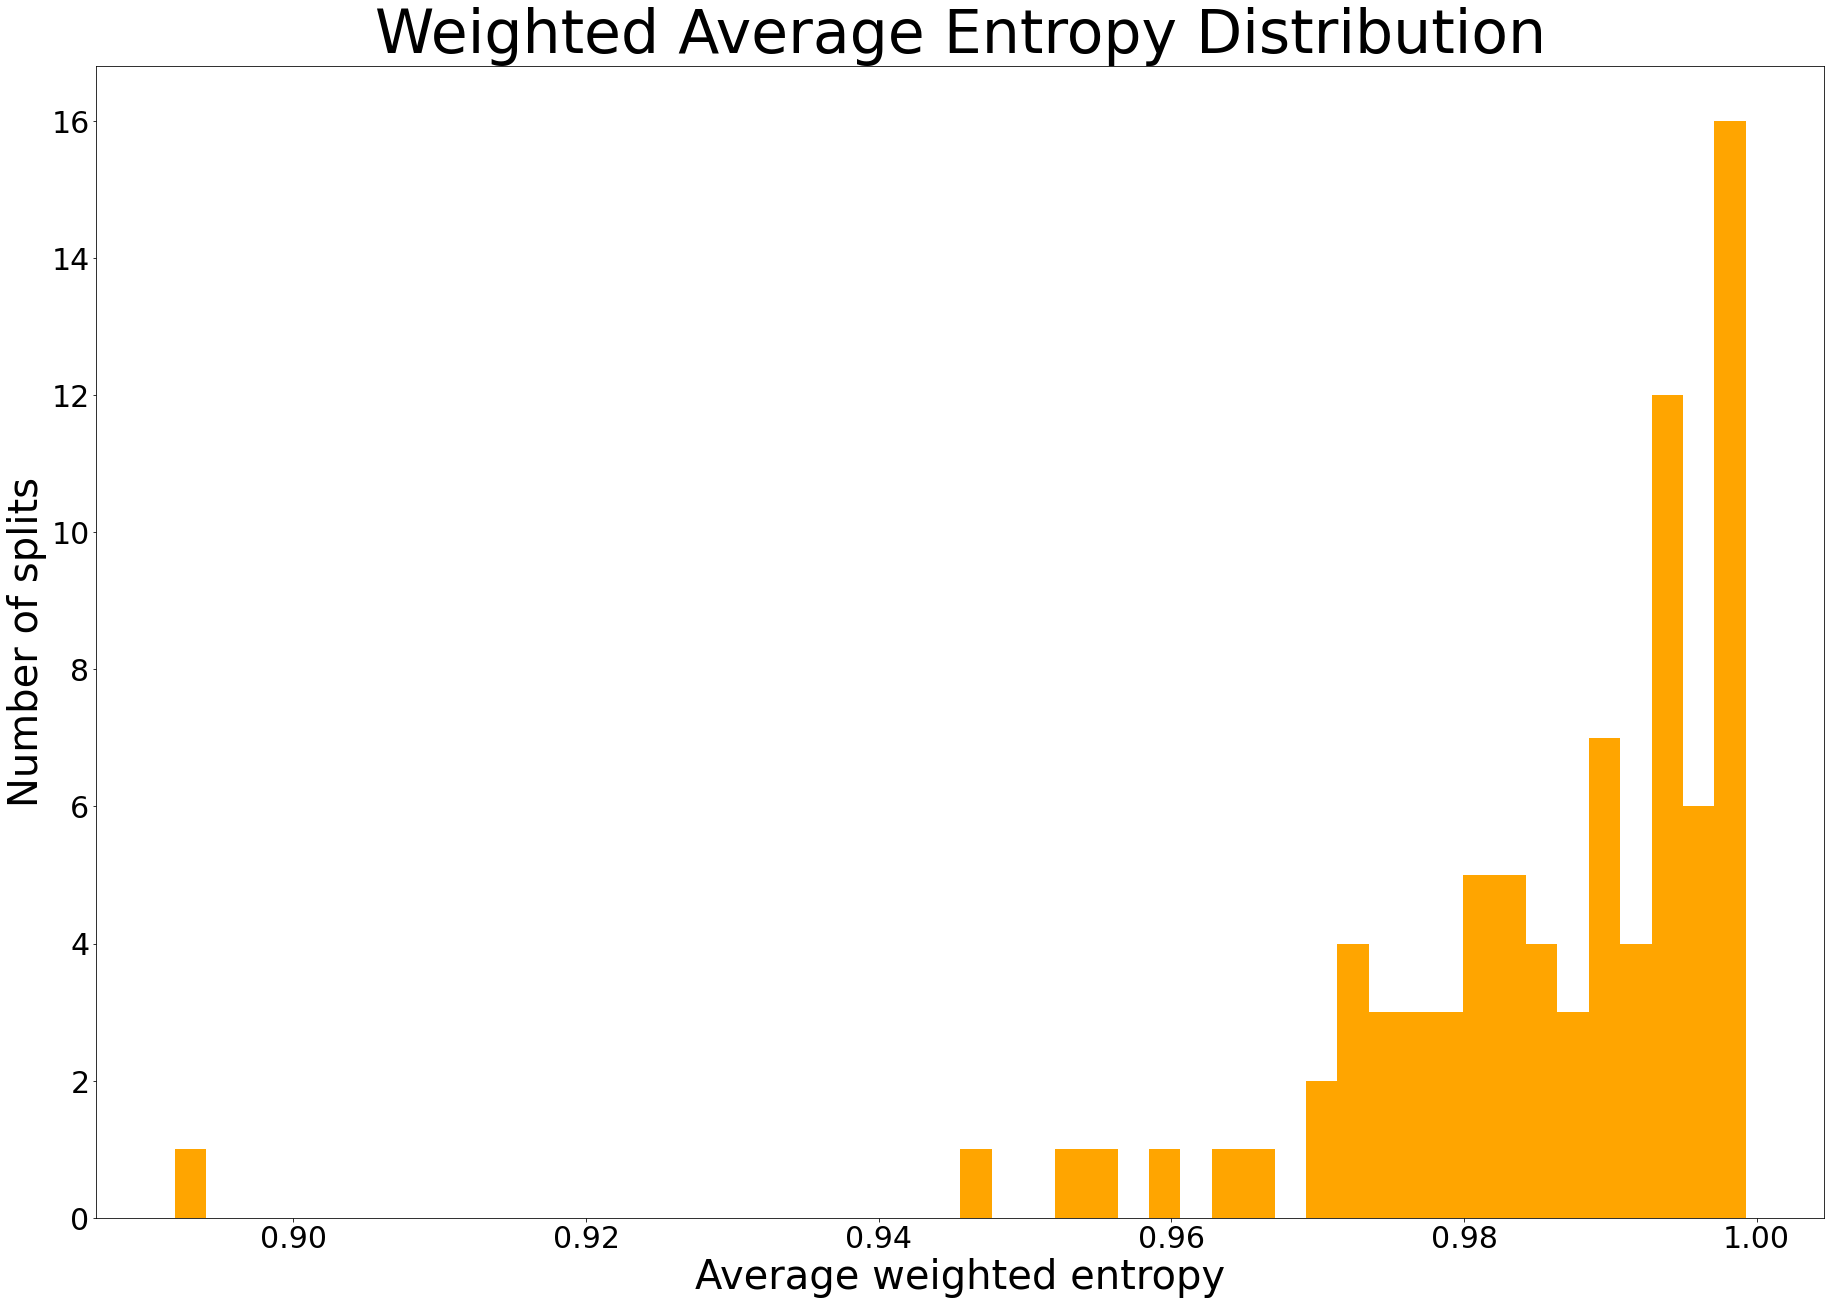

In [74]:
def createWAEDict(matrix, targetArray, topTeams):
    dictWAE = defaultdict(float)
    for index, team in enumerate(topTeams):
        groupTeam, groupNotTeam, TeamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeams, team)
        teamWAE = getSplitWAE(groupTeam, groupNotTeam, TeamTargetArray, notTeamTargetArray, matrix)
        dictWAE[team] = teamWAE
    return dictWAE

dictOfwae = createWAEDict(matrix, targetArray, topTeamsList)
counterWAE = Counter(dictOfwae)

fig, ax1 = plt.subplots()
ax1.hist(counterWAE.values(), color='orange', bins = 50)
ax1.set_title('Weighted Average Entropy Distribution', fontsize=60)
ax1.set_xlabel('Average weighted entropy', fontsize=40)
ax1.set_ylabel('Number of splits', fontsize=40)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
fig.subplots_adjust(left=0, right=4, bottom=0, top=4)

print("10 Lowest Entropies: ", counterWAE.most_common()[:-10-1:-1])
print("10 Highest Entropies: ", counterWAE.most_common(10))

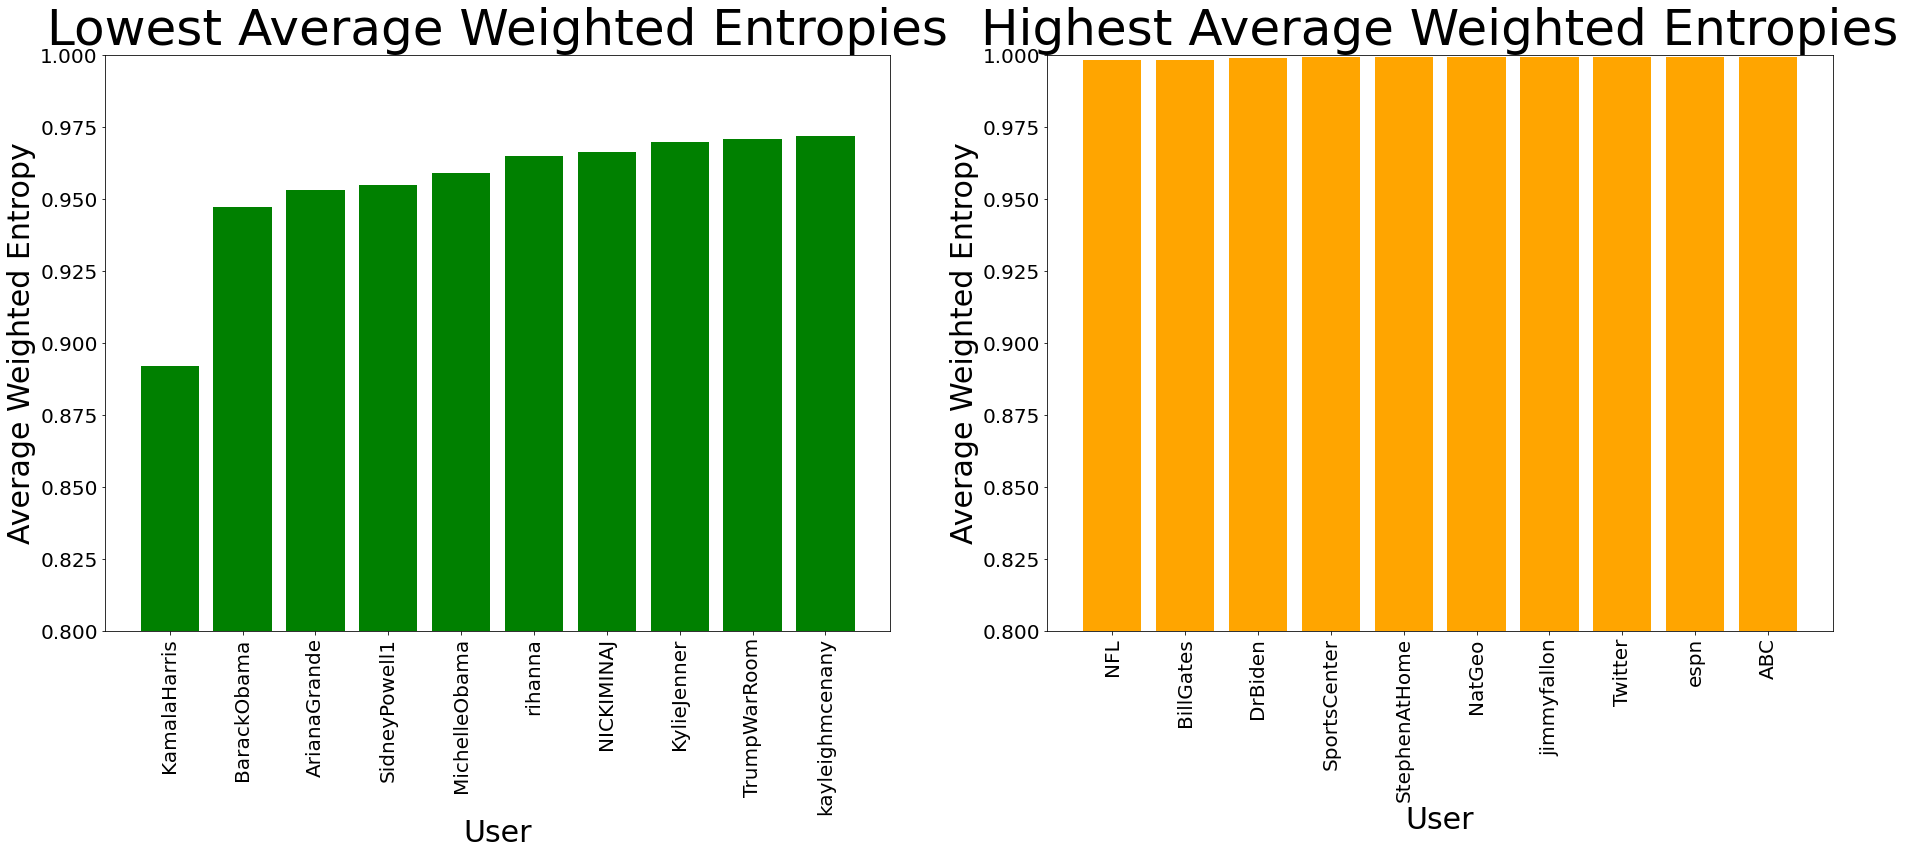

In [123]:
lowestEntropies = dict(counterWAE.most_common()[:-10-1:-1])
highestEntropies = dict(counterWAE.most_common(10)[::-1])


fig, ax = plt.subplots(1, 2)
ax[0].bar(lowestEntropies.keys(), lowestEntropies.values(), color='green')
ax[0].set_xlabel('User', fontsize=30)
ax[0].set_ylabel('Average Weighted Entropy', fontsize=30)
ax[0].tick_params(axis='x', rotation=90, labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Lowest Average Weighted Entropies', fontsize=50)
ax[0].set_ylim(.8,1)
ax[1].bar(highestEntropies.keys(), highestEntropies.values(), color='orange')
ax[1].set_xlabel('User', fontsize=30)
ax[1].set_ylabel('Average Weighted Entropy', fontsize=30)
ax[1].tick_params(axis='x', rotation=90, labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('Highest Average Weighted Entropies', fontsize=50)
ax[1].set_ylim(.8,1)

fig.subplots_adjust(left=0, right=4, top=2, bottom=0)

In [55]:
def findLowestSplit(dictOfWAE, matrix, topTeams, targetArray):
    sortedDict = sorted(dictOfWAE.items(), key = lambda x: x[1], reverse = False)
    return sortedDict[0][0]
team = findLowestSplit(dictOfwae, matrix, topTeamsList, targetArray)
print("Lowest entropy: ")
print(team)

Lowest entropy: 
KamalaHarris


In [53]:
def createTree(matrix, topTeams, targetArray):
    if len(matrix) < 5:
        return ""
    waeDict = createWAEDict(matrix, targetArray, topTeams)
    user = findLowestSplit(waeDict, matrix, topTeams, targetArray)
    if user != None:
        group1, group2, targetArray1, targetArray2 = createSubgroups(matrix, targetArray, topTeams, user)
    else:
        return ""
    print()
    print("Split by: ", user)
    print("Weighted entropy: ", waeDict[user])

    group1sEntropy = findShannonEntropy(group1, targetArray1, matrix)
    group2sEntropy = findShannonEntropy(group2, targetArray2, matrix)
    
    if group1sEntropy >= group2sEntropy:
        chaoticGroup = group1
        chaoticTA = targetArray1
        calmGroup = group2
        chaoticEntropy = group1sEntropy
        calmEntropy = group2sEntropy
    else:
        chaoticGroup = group2
        chaoticTA = targetArray2
        calmGroup = group1
        calmEntropy = group1sEntropy
        chaoticEntropy = group2sEntropy

    print("Chaotic group size: ", np.array(chaoticGroup).shape)
    print("Chaotic group entropy: ", chaoticEntropy)
    print("Calm group size: ", np.array(calmGroup).shape)
    print("Calm group entropy: ", calmEntropy)

    return createTree(chaoticGroup, topTeams, chaoticTA)
        

createTree(matrix, topTeamsList, targetArray)

    
    


Split by:  KamalaHarris
Weighted entropy:  0.8919094504999716
Chaotic group size:  (312, 84)
Chaotic group entropy:  0.9444774680894845
Calm group size:  (130, 84)
Calm group entropy:  0.7657462082851403

Split by:  ArianaGrande
Weighted entropy:  0.8978935697462439
Chaotic group size:  (288, 84)
Chaotic group entropy:  0.9111942950464766
Calm group size:  (24, 84)
Calm group entropy:  0.7382848661434506

Split by:  MichelleObama
Weighted entropy:  0.8715800100828932
Chaotic group size:  (275, 84)
Chaotic group entropy:  0.8835020886292702
Calm group size:  (13, 84)
Calm group entropy:  0.6193821946787638

Split by:  DonaldJTrumpJr
Weighted entropy:  0.8461128866074614
Chaotic group size:  (256, 84)
Chaotic group entropy:  0.9089103274103589
Calm group size:  (19, 84)
Calm group entropy:  -0.0

Split by:  whoisaddison
Weighted entropy:  0.8633097917268996
Chaotic group size:  (249, 84)
Chaotic group entropy:  0.8875795449079771
Calm group size:  (7, 84)
Calm group entropy:  -0.0

Spli

''

[[1. 0.]]
0


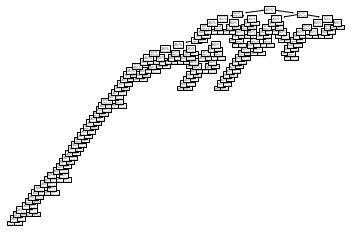

In [54]:
from sklearn import tree
import graphviz

clf = tree.DecisionTreeClassifier()
clf.fit(matrix, targetArray)

x = clf.predict_proba(matrix[340].reshape(1, -1))
print(x)
print(targetArray[340])

tree.plot_tree(clf)
dot_data = tree.export_graphviz(clf, out_file='decisionTree')
graph = graphviz.Source(dot_data)

## Making a Model

### We are going to train a model to predict the likelyhood of someone being either a Trump or Biden follower based on the other accounts (from the 84 teams) that they follow

#### First lets separate our data into a train and test set

In [56]:
trainX = matrix[25:-25]
trainY = targetArray[25:-25]
testX = np.concatenate((matrix[:25], matrix[-25:]), axis = 0)
testY = np.concatenate((targetArray[:25], targetArray[-25:]), axis = 0)

#### Now time to train our model. We have chosen to use BernoulliNB as our model from scikit-learn because it is easy to use and specifically designed for binary/boolean features

In [57]:
def evaluate(target, prediction):
    zipped = zip(target, prediction)
    FP = 0
    TP = 0
    FN = 0
    TN = 0
    for ans, pred in zipped:
        #print(ans, pred)
        if ans < pred:
            FP += 1
        elif ans > pred:
            FN += 1
        elif ans == 0:
            TP += 1
        elif ans == 1:
            TN += 1
        else:
            #print("error")
            pass
    return TP, TN, FP, FN

def train(model, trainingMatrix, trainingTargetArray, testMatrix, testTargetArray):
    model.fit(trainingMatrix, trainingTargetArray)
    prediction = model.predict(testMatrix)
    return evaluate(testTargetArray, prediction)

In [58]:
modelTrain = BernoulliNB()
print("Evaluated on training data\n")
TP, TN, FP, FN = train(modelTrain, trainX, trainY, trainX, trainY)
print("accuracy:", (TP + TN)/(TP + TN + FP + FN))
precision = (TP)/(TP + FP)
recall = (TP)/(TP + FN)
print("precision:", (TP)/(TP + FP))
print("recall:", (TP)/(TP + FN))
print("F1:", (2 * precision * recall)/(precision + recall))

modelTest = BernoulliNB()
print("\n\nEvaluated on test data\n")
TP, TN, FP, FN = train(modelTest, trainX, trainY, testX, testY)
print("accuracy:", (TP + TN)/(TP + TN + FP + FN))
precision = (TP)/(TP + FP)
recall = (TP)/(TP + FN)
print("precision:", (TP)/(TP + FP))
print("recall:", (TP)/(TP + FN))
print("F1:", (2 * precision * recall)/(precision + recall))

Evaluated on training data

accuracy: 0.7321428571428571
precision: 0.5925925925925926
recall: 0.8
F1: 0.6808510638297872


Evaluated on test data

accuracy: 0.68
precision: 0.6
recall: 0.7142857142857143
F1: 0.6521739130434783


#### Above we can see that our accuracy is lower if we evaluate our model on separated test data. This likely points to the fact that with only 482 data points, our model quickly overfits

## Histograms

#### 

In [134]:
def createDicts(matrix, targetArray, topTeams):
    dictBiden = {}
    dictTrump = {}
    for index, team in enumerate(topTeams):
        listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, team)
        countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
        dictBiden[team] = countBiden
        dictTrump[team] = countTrump
    return dictBiden, dictTrump

BidenDict, TrumpDict = createDicts(matrix, targetArray, topTeamsList)

In [64]:
countedBidenDict = Counter(BidenDict)
topTenBiden = countedBidenDict.most_common(10)
bottomTenBiden = countedBidenDict.most_common()[-10:-1]
print(topTenBiden)
print()
countedTrumpDict = Counter(TrumpDict)
topTenTrump = countedTrumpDict.most_common(10)
bottomTenTrump = countedBidenDict.most_common()[-10:-1]

topTenBiden = dict(topTenBiden)
topTenTrump = dict(topTenTrump)

def allignTopTenTrump(topTenBiden, topTenTrump):
    trumperDict =  {}
    for key in topTenBiden.keys():
        listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, key)
        countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
        trumperDict[key] = countTrump
    return trumperDict

ourTrumperDict = allignTopTenTrump(topTenBiden, topTenTrump)


def allignTopTenBiden(topTenBiden, topTenTrump):
    BidenDicked =  {}
    for key in topTenTrump.keys():
        listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, key)
        countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
        BidenDicked[key] = countBiden
    return BidenDicked

ourBidenDict = allignTopTenBiden(topTenBiden, topTenTrump)
print(ourBidenDict)
topTenBiden = dict(topTenBiden)
topTenTrump = dict(topTenTrump)

[('KamalaHarris', 101), ('BarackObama', 99), ('MichelleObama', 49), ('ArianaGrande', 42), ('POTUS', 38), ('CNN', 38), ('HillaryClinton', 38), ('AOC', 38), ('rihanna', 36), ('cnnbrk', 34)]

{'POTUS': 38, 'BarackObama': 99, 'VP': 10, 'WhiteHouse': 25, 'FLOTUS': 14, 'KamalaHarris': 101, 'DonaldJTrumpJr': 5, 'IvankaTrump': 7, 'CNN': 38, 'cnnbrk': 34}


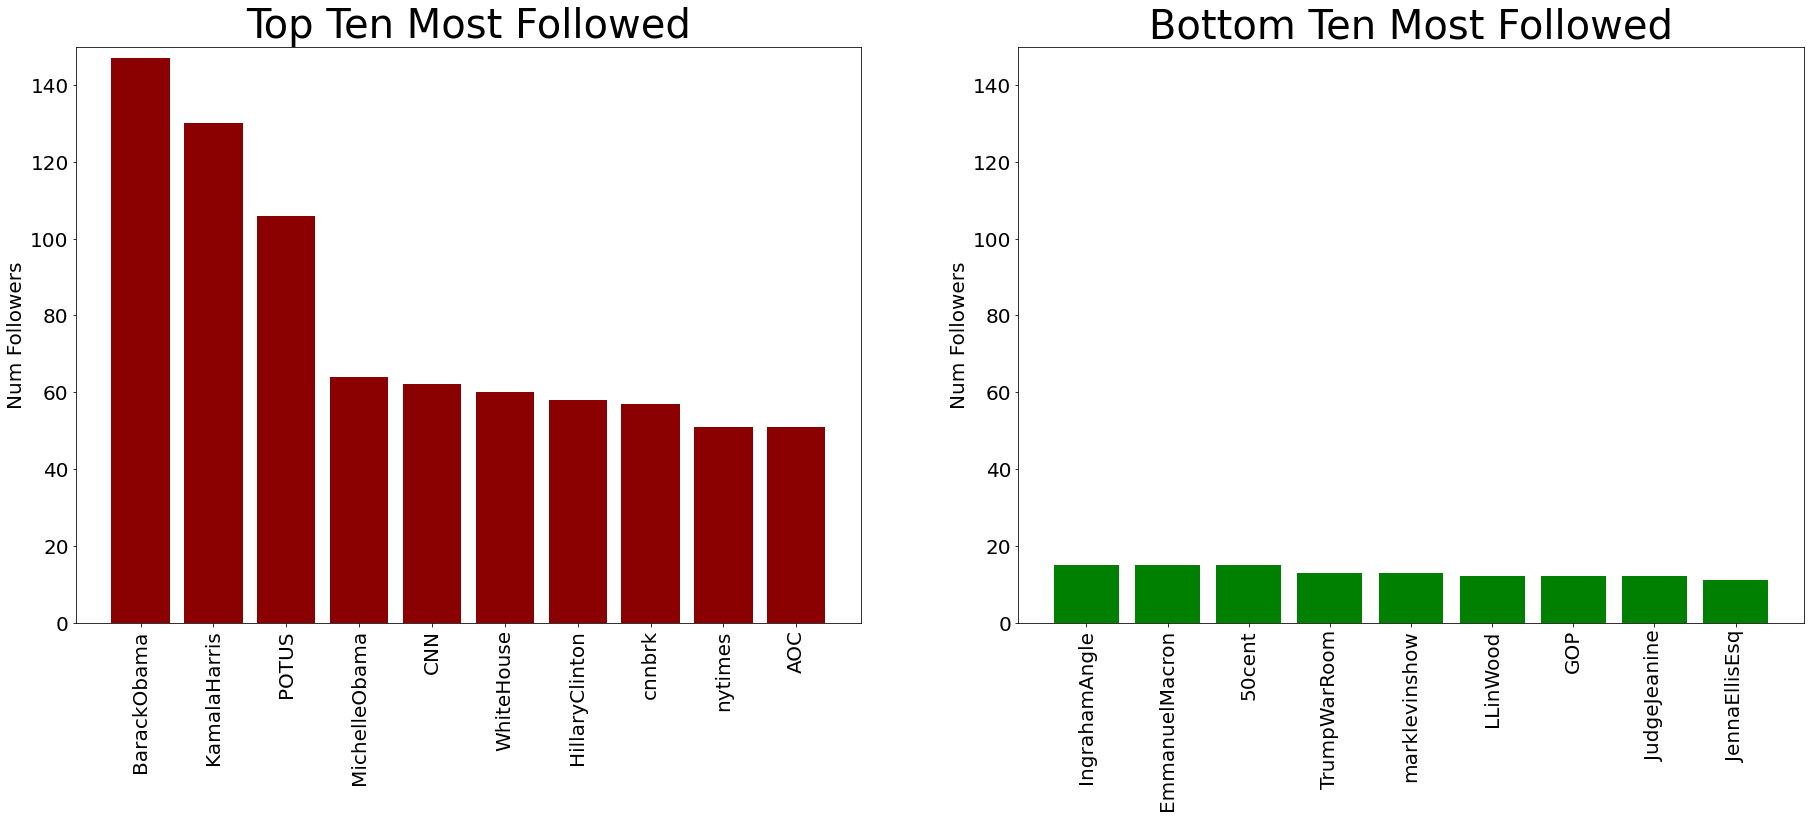

In [165]:
def merge_two_dicts(dict1, dict2):
    both = dict1.copy()   
    both.update(dict2)    
    return both

totalCounter = merge_two_dicts(countedBidenDict, countedTrumpDict)
topTenMostFollowed = dict(totalCounter.most_common(10))
bottomTenMostFollowed = dict(totalCounter.most_common()[-10:-1])

fig, ax = plt.subplots(1, 2)
ax[0].bar(topTenMostFollowed.keys(), topTenMostFollowed.values(), color='darkred')
ax[0].tick_params(axis='x', rotation=90, labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_ylim(0,150)
ax[0].set_ylabel('Num Followers', fontsize=20)
ax[0].set_title('Top Ten Most Followed', fontsize=40)
ax[1].bar(bottomTenMostFollowed.keys(), bottomTenMostFollowed.values(), color='green')
ax[1].tick_params(axis='x', rotation=90, labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_ylim(0,150)
ax[1].set_ylabel('Num Followers', fontsize=20)
ax[1].set_title('Bottom Ten Most Followed', fontsize=40)

fig.subplots_adjust(left=0, right=4, top=2, bottom=0, hspace=.75)

In [ ]:
plt.bar(totalCounter)

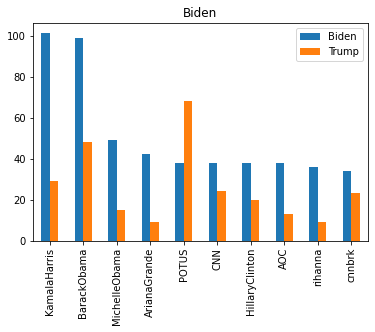

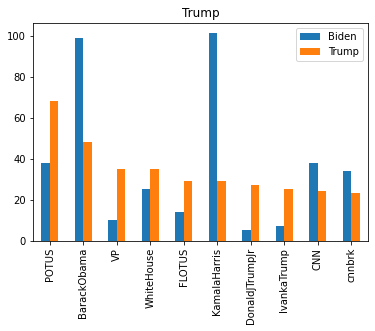

In [125]:
bidenGraph1 = pd.DataFrame(dict(Biden=list(dict(topTenBiden).values()), Trump=list(dict(ourTrumperDict).values())), index=topTenBiden.keys())
bidenGraph = bidenGraph1.plot.bar(title="Biden")


trumpGraph1 = pd.DataFrame(dict(Biden=list(dict(ourBidenDict).values()), Trump=list(dict(topTenTrump).values())), index=topTenTrump.keys())
trumpGraph = trumpGraph1.plot.bar(title="Trump")

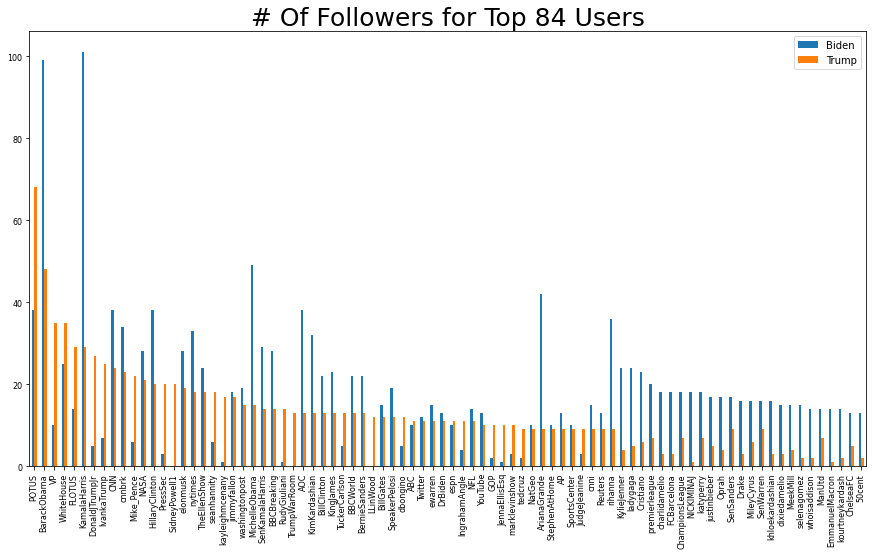

In [132]:
allGraph = pd.DataFrame(dict(Biden=list(BidenDict.values()), Trump=list(TrumpDict.values())), index=TrumpDict.keys())
bothGraph = allGraph.plot.bar(title="# Of Followers for Top 84 Users", fontsize=8, figsize=(15,8))
bothGraph.title.set_size(25)